## Auto-mpg<br>
Workflow should be:
1. Exploring Auto-mpg dataset
2. Train models to regress on Auto-mpg dataset
3. Apply explanation methods and visualize the effect
4. Evaluate explanation methods with several metrics

focus is not how accurate the model's predictions are, __instead focus on how each explanation methods is explaining the model <span style="color: red;">(fidelity, accuracy, predictable, stability, consistency, explicitness, certainty)</span>. Therefore, I only perform necessary preprocessing stages.__ What's more, since data size is small, I extract extra data points from current time for prediction.
<br>
My initial thought is
1. Preprocessing
2. Train model.
3. Apply explanation methods
4. Evaluation

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from slisemap import Slisemap

In [2]:
autompg = pd.read_csv('Datasets/auto_mpg.csv', na_values='?')
X0 = autompg[[
    'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin',
]]
y0 = autompg['mpg']

origin_mapping = {origin: idx for idx, origin in enumerate(autompg['origin'].unique())}
X0['origin_mapped'] = X0['origin'].map(origin_mapping)
origin_indices = X0['origin_mapped'].values.astype(int)
oh_origin = np.eye(len(origin_mapping))[origin_indices]

X0 = np.concatenate(
    (X0.values[:, :-2].astype(float), oh_origin), axis=1,
)
y0 = y0.values

mask = ~np.isnan(X0[:, 2])
X0 = X0[mask]
y0 = y0[mask]

names = list(autompg.columns[1:-2]) + ['origin US', 'origin JP', 'origin EU']
names

C:\Users\Localadmin_mudonggu\AppData\Local\Temp\ipykernel_5096\932044074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X0['origin_mapped'] = X0['origin'].map(origin_mapping)


['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year',
 'origin US',
 'origin JP',
 'origin EU']

#### preprocessing
1. __Centered around median (but not normalized with MAD)__: cylinder, displacement, weight, acceleration, model_year
2. __Impute with median and centered around median__
3. __One-hot Encode (with dropping 1)__: origin
4. __Extract company & One-hot encode (with dropping 1)__: name

Median-centered & Drop 1 during one hot encoding enables compare the feature important with reference.

In [3]:
scale_x = StandardScaler()
scale_y = StandardScaler()
X = np.concatenate([scale_x.fit_transform(X0[:, :-3]), X0[:, -3:]], axis=1)
y = scale_y.fit_transform(y0[:, None])

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### model training stage.
1. Underfitted model: Sparse linear model with Lasso
2. Proper model: Sparse Linear model with Lasso (smaller penalty), SVR, and k-NN
3. Overfitted model: Poly Linear

__The trained models shall be stored__

In [5]:
random_forest = RandomForestRegressor(random_state=42).fit(X, y.ravel())
y2 = random_forest.predict(X)

#### Applying explanation method
PDP, ALE, prototyping, LIME, SHAP, SLISEMAP

In [7]:
# Structure
pd.DataFrame(X, columns=names)

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin US,origin JP,origin EU
0,-0.864014,-0.826826,-0.272342,-0.705613,0.347933,-0.809884,0.0,1.0,0.0
1,0.309967,0.053468,-0.506461,-0.460422,0.166467,-1.625315,1.0,0.0,0.0
2,-0.864014,-0.721574,-0.324369,-0.640778,-0.196464,1.092789,0.0,1.0,0.0
3,0.309967,0.043900,-0.376395,-0.388515,-0.196464,-1.625315,1.0,0.0,0.0
4,0.309967,0.531890,-0.116263,0.422502,0.529398,-0.538074,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
269,1.483947,1.048584,1.184397,1.077916,-1.103792,-1.081695,1.0,0.0,0.0
270,0.309967,0.359658,-0.116263,-0.222304,-0.196464,-0.809884,1.0,0.0,0.0
271,-0.864014,-0.415384,-0.506461,-0.144503,0.747157,0.549168,1.0,0.0,0.0
272,-0.864014,-0.922511,-1.026725,-0.704434,1.872244,1.364599,1.0,0.0,0.0


Loss: 6.621878623962402


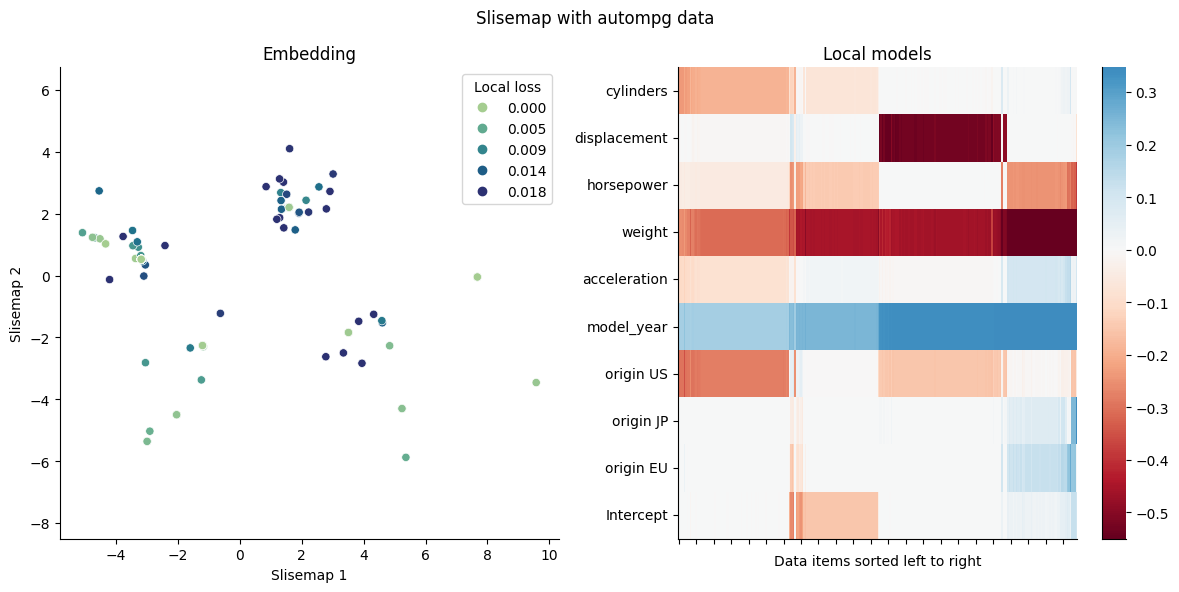

In [9]:
# Slisemap
sm = Slisemap(X, y2, lasso=0.01, random_state=42)
sm.optimise()
print(f"Loss: {sm.value()}")
sm.metadata.set_variables(names) # Store variable names
sm.metadata.set_targets("MPG") # Store target names
sm.metadata.set_scale_Y(scale_y.mean_, scale_y.scale_) # Store y normalisation
sm.metadata.set_scale_X(  # Store X normalisation
    np.concatenate((scale_x.mean_, np.zeros(3))), 
    np.concatenate((scale_x.scale_, np.ones(3)))
)
sm.plot(title="Slisemap with autompg data")

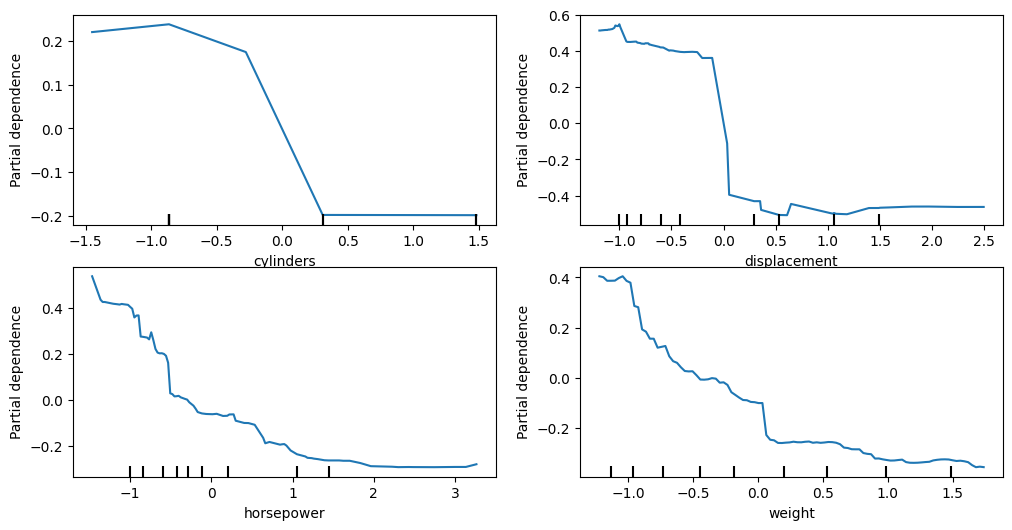

In [23]:
# PDP - Single feature
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
for i, ax in enumerate(ax.flat):
    pdp_boston = PartialDependenceDisplay.from_estimator(random_forest, X, features=[i], feature_names=names, ax=ax)

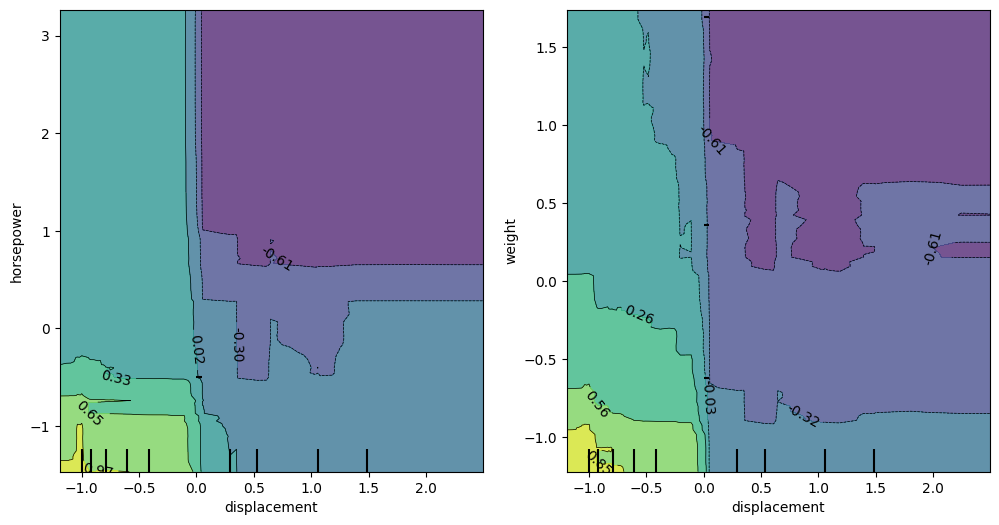

In [11]:
# PDP - Two features
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdp_boston = PartialDependenceDisplay.from_estimator(random_forest, X, features=[(1, 2)], feature_names=names, ax=ax[0])
pdp_boston = PartialDependenceDisplay.from_estimator(random_forest, X, features=[(1, 3)], feature_names=names, ax=ax[1])

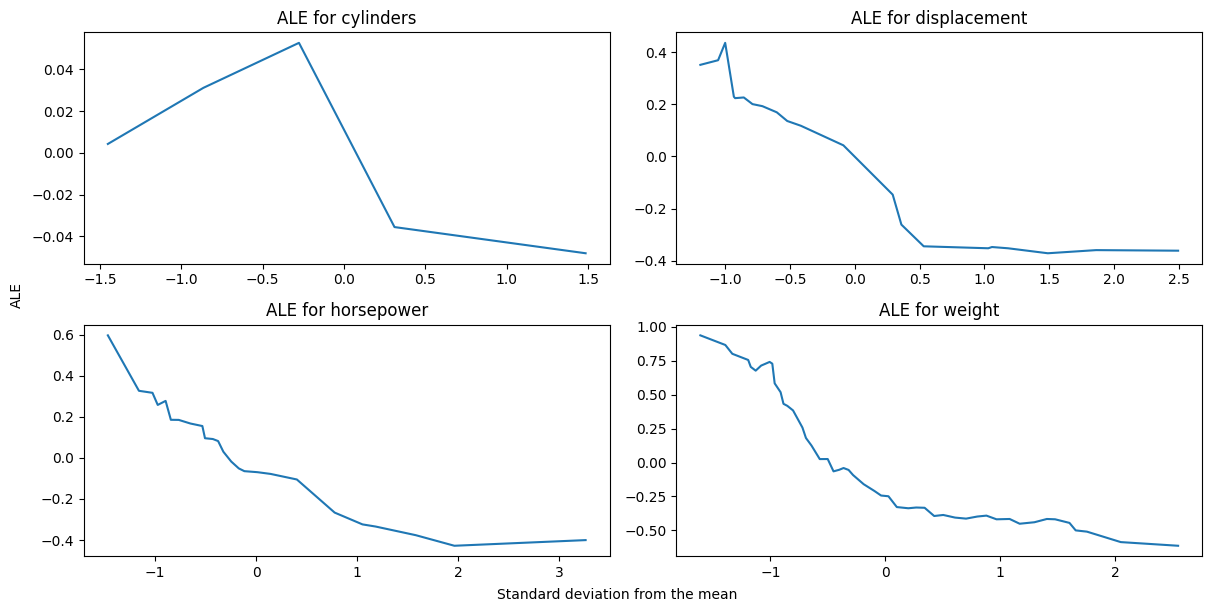

In [24]:
from alibi.explainers import ALE, plot_ale
ale = ALE(random_forest.predict, feature_names=names, target_names="MPG")
exp = ale.explain(X)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    feature = exp.feature_values[i]
    ax.plot(exp.feature_values[i], exp.ale_values[i])
    ax.set_title(f'ALE for {names[i]}')
fig.text(0.5, 0., 'Standard deviation from the mean', ha='center', va='center')
fig.text(0., 0.5, 'ALE', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

Loss: 9.06107234954834


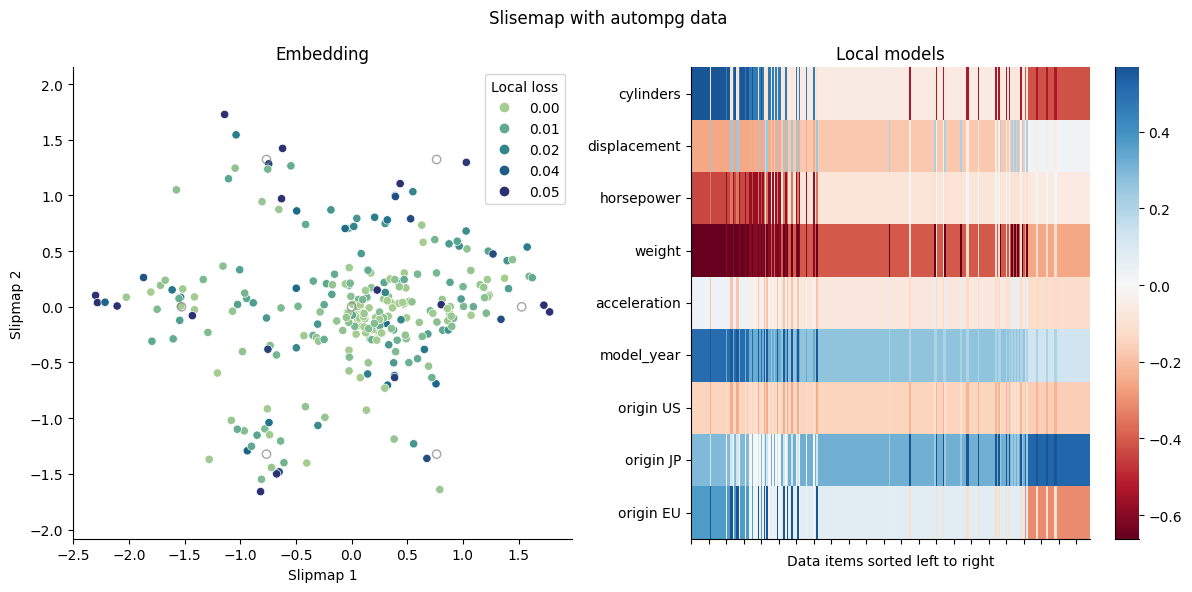

In [39]:
# More slisemaps
from slisemap import Slipmap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
sm2 = Slipmap(
    X,
    y2,
    lasso=1e-3,
    radius=1.,
    intercept=False,
)

sm2.optimise()
print(f"Loss: {sm2.value()}")
sm2.metadata.set_variables(names) # Store variable names
sm2.metadata.set_targets("MPG") # Store target names
sm2.metadata.set_scale_Y(scale_y.mean_, scale_y.scale_) # Store y normalisation

sm2.plot(title="Slisemap with autompg data")

Loss: 10.510887145996094


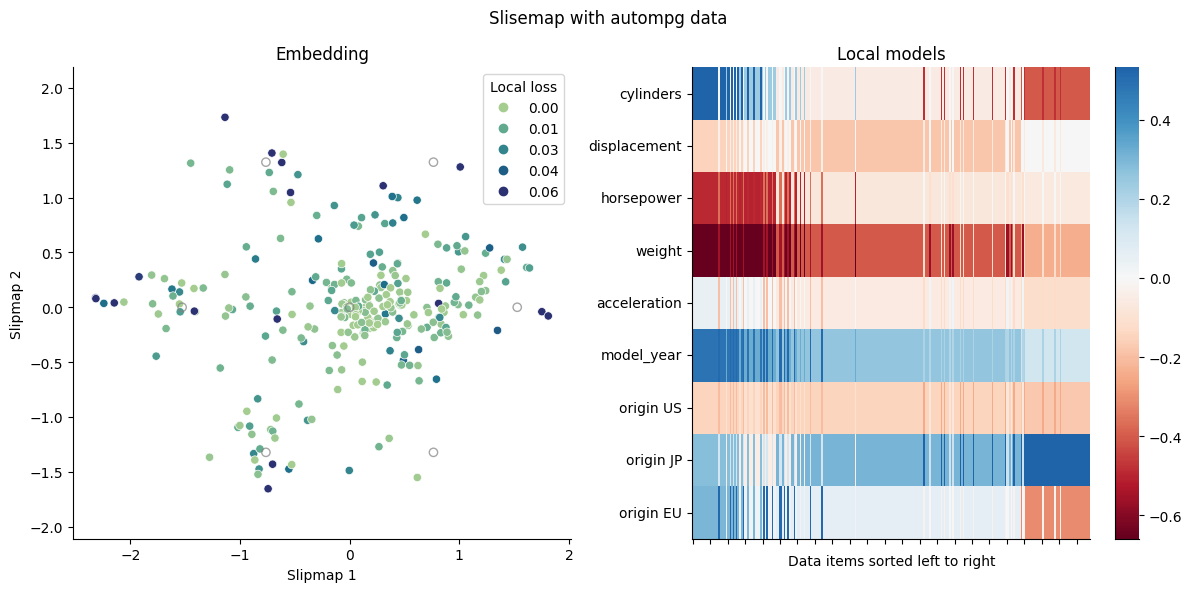

In [41]:
sm2.lasso = 1e-1
sm2.optimise()
print(f"Loss: {sm2.value()}")
sm2.plot(title="Slisemap with autompg data")

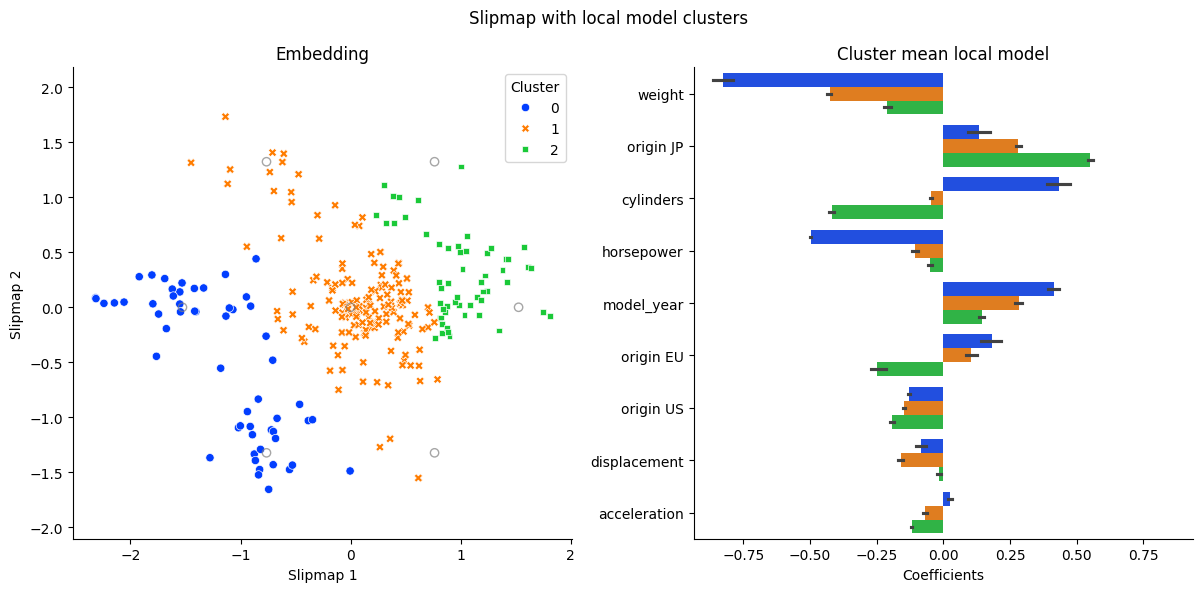

In [43]:
clusters = 3
bars = 10
sm2.plot(
    title="Slipmap with local model clusters",
    clusters=clusters,
    bars=bars,
)

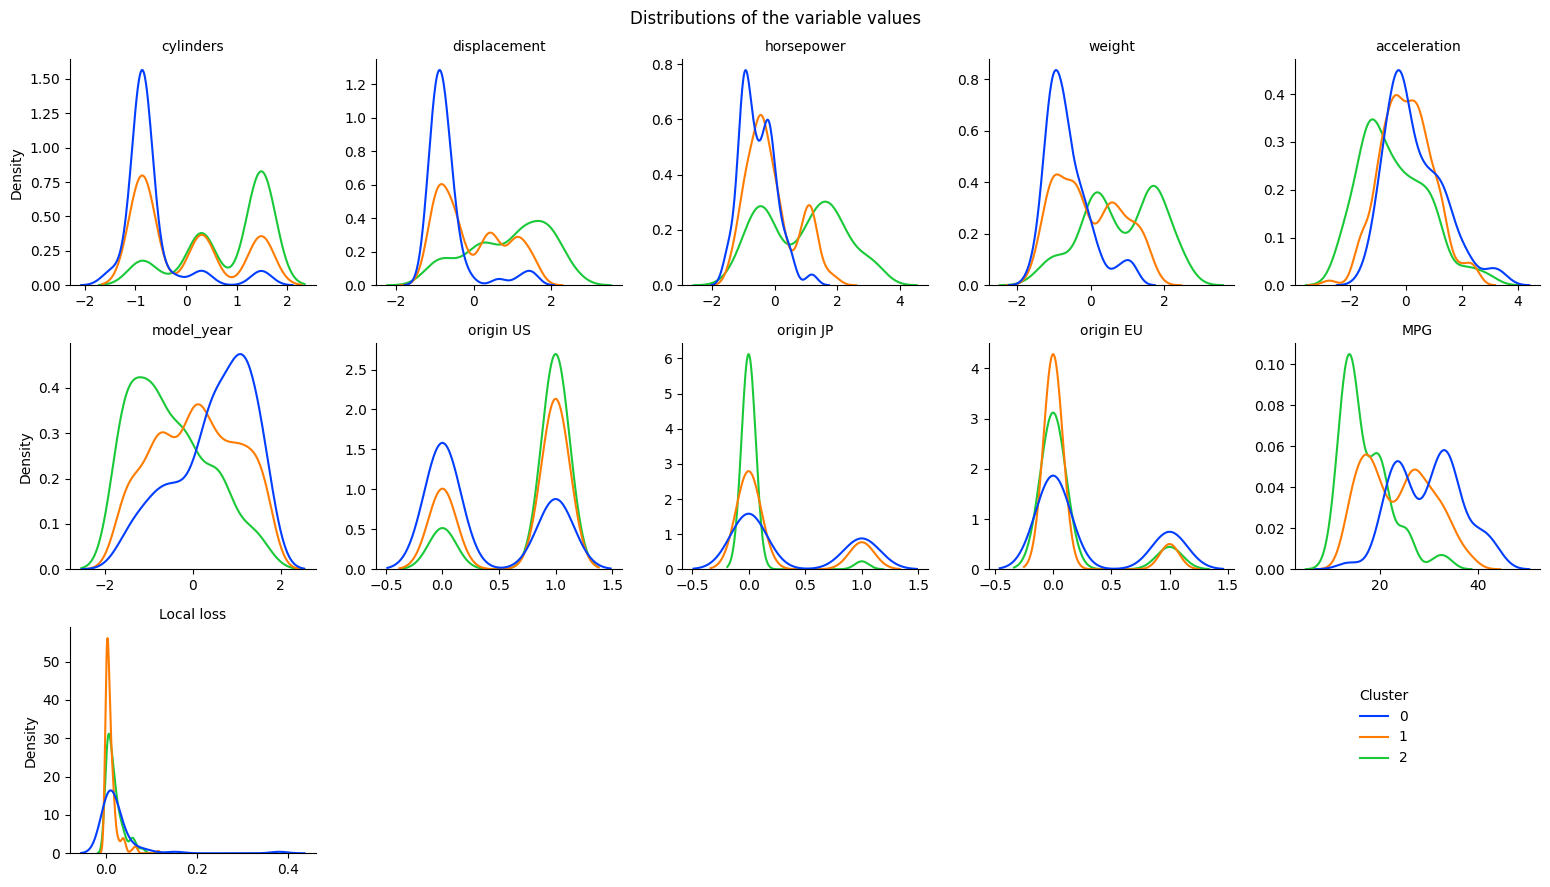

In [44]:
# dist
sm2.plot_dist(
    title="Distributions of the variable values",
    clusters=clusters,
    height=3,
    col_wrap=5,
)

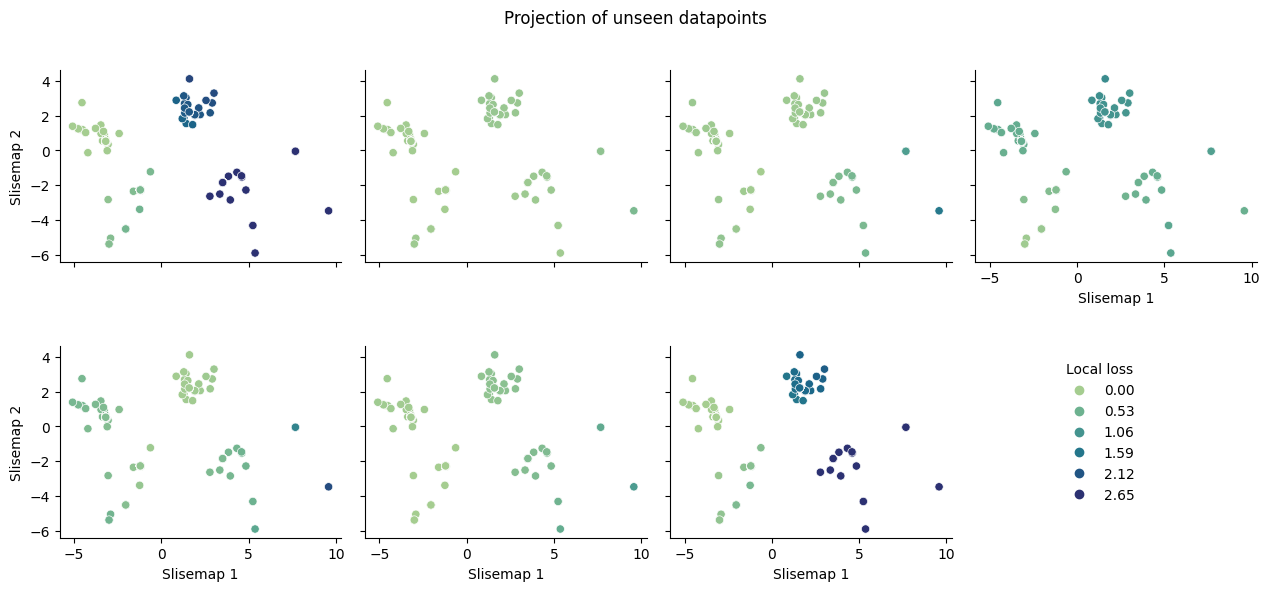

In [45]:
# Unseen data
np.random.seed(42)
sel = np.random.randint(0, X_test.shape[0], 7)
sm.plot_position(
    X_test[sel],
    y_test[sel],
    title="Projection of unseen datapoints",
    height=3,
)

## Reproduce examples in Slisemap